# A quick demo for context specification problem in FSVI

This notebook provides a quick demo of the 2D example we used in Section 1 (Introduction).

**Implementation contents:**

(1) We first illustrate how different empirical context specifications affect the performance of Function Space Variational Inference (FSVI), including:

- (i) Parameter-space variational inference (PSVI) without context set $\mathcal{C}$
- (ii) FSVI with context set $\mathcal{C}$ covering the training distribution region
- (iii) FSVI with context set $\mathcal{C}$ concentrating on a right-top out-of-distribution (OOD) region
- (iv) FSVI with context set $\mathcal{C}$ concentrating on a left-bottom OOD region
- (v) FSVI with context set $\mathcal{C}$ covering a broad OOD region
- (vi) FSVI with context set $\mathcal{C}$ covering a **_“boundary”_** region **(Ours)**

_Note that here, the newly proposed KL divergence cost function (Eq. (4)) is used for all the context sets._

(2) Then, the performance of two different function-space cost functions are compared:

- (i) Our newly proposed KL divergence cost function defined in Eq. (4):

$$
\operatorname{cost}(\mathcal{C}, \boldsymbol{\theta})=\beta \sum_{m=1}^M \operatorname{KL}\left(f\left(\hat{\mathbf{x}}_m ; \boldsymbol{\theta}\right) \| \mathcal{U}\right),  \text { where } \operatorname{KL}\left(f\left(\widehat{\mathbf{x}}_m ; \boldsymbol{\theta}\right) \| \mathcal{U}\right)=\sum_{k=1}^K f\left(\widehat{\mathbf{x}}_m ; \boldsymbol{\theta}\right)_k \log \frac{f\left(\widehat{\mathbf{x}}_m ; \boldsymbol{\theta}\right)_k}{\mathcal{U}_k}
$$

- (ii) Mahalanobis distance cost function defined in Appendix Eq. (S12):

$$
\operatorname{cost}(\mathcal{C}, \boldsymbol{\theta})=\beta \sum_{k=1}^K\left(f(\widehat{\mathbf{X}} ; \boldsymbol{\theta})_k-\mathcal{U}\right)^{\top} C^{-1}(\widehat{\mathbf{X}})\left(f(\widehat{\mathbf{X}} ; \boldsymbol{\theta})_k-\mathcal{U}\right), \text { where } C(\widehat{\mathbf{X}})=h(\widehat{\mathbf{X}}) h^{\top}(\widehat{\mathbf{X}})+s \mathbf{I}
$$
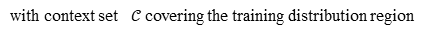
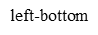

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import bayesianize.bnn as bnn
from models import fnn
from data_loader import get_two_gaussian
from helpers import seed_everything, mahalanobis_distance_cost_function
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Plot training points generated by a mixture of Gaussians
def plot_train_loader(train_loader, size=100):
    all_data = []
    all_labels = []

    for batch_data, batch_labels in train_loader:
        all_data.append(batch_data)
        all_labels.append(batch_labels)
    data = torch.cat(all_data, dim=0).numpy()  # [N, 2]
    labels = torch.cat(all_labels, dim=0).numpy()  # [N]

    class0 = data[labels == 0]
    class1 = data[labels == 1]
    plt.scatter(class0[:, 0], class0[:, 1], marker='o', color='cornflowerblue', edgecolors='black', s=size)
    plt.scatter(class1[:, 0], class1[:, 1], marker='o', color='tomato', edgecolors='black', s=size)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()

# Plot context samples with different position relationships to training distribution
def plot_context_loader(ood_loader, size=80, color="lime"):
    all_data = []
    all_labels = []

    for batch_data, batch_labels in ood_loader:
        all_data.append(batch_data)
        all_labels.append(batch_labels)
    data = torch.cat(all_data, dim=0).numpy()  # [N, 2]

    plt.scatter(data[:, 0], data[:, 1], marker='*', color=color, edgecolors='springgreen', s=size, alpha=0.5)

# Plot the (blur/red) decision bound of BNN classifier
def plot_decision_bound(model, range=(-30, 30), cbar=False):
    x1 = np.linspace(*range, 100)
    x2 = np.linspace(*range, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    grid_data = np.c_[xx1.ravel(), xx2.ravel()]

    grid_tensor = torch.tensor(grid_data, dtype=torch.float32).to('cuda')
    with torch.no_grad():
        pred_probs = torch.nn.functional.softmax(model(grid_tensor), dim=1)[:, 1].cpu().numpy()

    plt.contourf(xx1, xx2, pred_probs.reshape(xx1.shape), alpha=1, levels=np.linspace(0, 1, 21), cmap='coolwarm', vmin=0, vmax=1)

    if cbar:
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=12)

    plt.xlim(*range)
    plt.ylim(*range)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

**`run_fsvi()` is the main function to run the FSVI with (i) different context specifications and (ii) cost functions.**
- (i) `context_type` parameter is used to specify the context set $\mathcal{C}$ with different positional relationships relative to the training distribution. The optional values are (see Fig. 1 in the paper):
  - `none`: No context set, equivalent to PSVI.
  - `cover`: Context set covering the training distribution region.
  - `right-top-far`: Context set concentrating on a right-top OOD region.
  - `left-bottom-far`: Context set concentrating on a left-bottom OOD region.
  - `sparse-margin`: Context set covering a broad OOD region.
  - `compact-margin`: Context set covering a **_“boundary”_** region **(Ours)**.
- (ii) `cost_type` parameter is used to specify the cost function for FSVI. The optional values are:
  - `none`: No cost function, equivalent to PSVI.
  - `kl_cost`: KL divergence cost function defined in Eq. (4) in the paper.
  - `md_cost`: Mahalanobis distance cost function defined in Appendix Eq. (S12).

In [3]:
# Run FSVI with different context specifications and cost functions (KL divergence and Mahalanobis distance)
def run_fsvi(context_type="cover", cost_type="kl_cost",
             epochs=500, batch_size=48, learning_rate=1e-3, beta=0.05, device="cuda", plot_interval=100):
    net = fnn(nin=2, nhid=500)
    seed_everything(111)

    # Initialize BNN classifier
    bnn.bayesianize_(net, inference='ffg', init_sd=0.0001, local_reparameterization=False, prior_weight_sd=1000,
                     prior_bias_sd=1000)
    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_loader, context_loader = get_two_gaussian(batch_size=batch_size, context_type=context_type)

    for epoch in range(1, epochs + 1):
        epoch_nll, epoch_kl, epoch_loss, epoch_acc, epoch_cost = [], [], [], [], []
        for (data, target), (ood_data, _) in zip(train_loader, context_loader):
            data, target = data.to(device), target.to(device)
            ood_data = ood_data.to(device)
            net.train()
            optimizer.zero_grad()

            # dELBO loss for Training data, see Eq. (5) in the paper
            preds_f = net(data)
            nll = F.cross_entropy(preds_f, target)
            kl = sum(m.kl_divergence() for m in net.modules() if hasattr(m, "kl_divergence"))
            acc = torch.sum(torch.argmax(preds_f, dim=1) == target).item() / len(target)

            # dELBO loss for Context data, see Eq. (6) in the paper
            preds_f_ood, preds_feature_ood = net(ood_data,
                                                 feature=True)  # preds_f_ood = [batch_size, 2], preds_feature_ood = [batch_size, 500]
            uniform_dist = torch.Tensor(preds_f_ood.size(0), 2).fill_((1. / 2)).to(device)  # [batch_size, 2]

            # Perform PSVI without context set
            if cost_type == "none":
                cost = torch.tensor(0.0).to(device)
            # Perform FSVI with different cost functions
            else:
                if cost_type == "kl_cost":
                    cost = beta * F.kl_div(F.log_softmax(preds_f_ood, dim=1), uniform_dist, reduction='mean') * 2
                elif cost_type == "md_cost":
                    cost = mahalanobis_distance_cost_function(preds_f_ood, preds_feature_ood, beta=beta)

            loss = nll + 0.1 * kl + cost

            loss.backward()
            optimizer.step()

            epoch_nll.append(nll.item())
            epoch_kl.append(kl.item())
            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
            epoch_cost.append(cost.item())

        if (epoch + 1) % plot_interval == 0:
            print(f"Epoch: [{epoch+1}/{epochs}]: "
                  f"NLL-loss: {sum(epoch_nll) / len(epoch_nll):.4f}, KL-loss: {sum(epoch_kl) / len(epoch_kl):.4f}, "
                  f"Loss: {sum(epoch_loss) / len(epoch_loss):.4f}, Accuracy: {sum(epoch_acc) / len(epoch_acc):.4f}, "
                  f"Cost: {sum(epoch_cost) / len(epoch_cost):.4f}")
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})
    plt.subplots_adjust(wspace=-1)

    plt.sca(axes[0])
    plot_decision_bound(net, range=(-30, 30))
    plot_train_loader(train_loader, size=100)
    if cost_type != "none":
        plot_context_loader(context_loader, size=30 if cost_type == "gan" else 60,
                            color="green" if cost_type in ["sparse-margin", "compact-margin", "compact-margin", "left-bottom-far", "right-top-far"] else "lime")
    # plt.title(f"Predictive distribution", fontsize=12)

    plt.sca(axes[1])
    plot_decision_bound(net, range=(-5, 5), cbar=True)
    plot_train_loader(train_loader, size=120)
    if cost_type != "none":
        plot_context_loader(context_loader, size=200, color="green" if cost_type in ["sparse-margin", "compact-margin", "left-bottom-far", "right-top-far"] else "lime")
    # plt.title(f"Zoom in interval [-5, 5]", fontsize=12)
    plt.tight_layout()

    plt.savefig(f'../output/figsInPaper/fig1/{cost_type}_{context_type}.png', bbox_inches='tight', dpi=600)
    plt.show()

## Implementation content (1): Different context specifications comparison

Here, the impact of different context datasets on the model's predictive performance is compared in a 2D dataset (see Fig. 1 in the paper). Training data for positive (red) and negative (blue) classes are shown. The entire input space is $[-30,30]^2$. OOD data consists of all points outside the training region. PSVI (Eq. (1)) and FSVI methods (Eq. (5)) with different context sets $\mathcal{C}$ (green) are used to optimize the classifier variational distribution $q(\boldsymbol{\theta})$. After training, the posterior predictive function $\mathbb{E}_{q(\boldsymbol{\theta})}\left[f\left(\mathbf{x}_* ; \boldsymbol{\theta}\right)\right]$ is plotted for all points $\mathbf{x}_*$ in the entire space (Left) and the zoomed-in region $[-5,5]^2$ (Right).

### Case (i): PSVI without context set $\mathcal{C}$
This is equivalent to the standard PSVI learning process without any context set. The resulst shows that the model produces over-confident predictions (predictive probabilities close to 0 or 1) in almost all OOD regions.

Epoch: [100/500]: NLL-loss: 0.0000, KL-loss: 7615935.0000, Loss: 761593.5125, Accuracy: 1.0000, Cost: 0.0000
Epoch: [200/500]: NLL-loss: 0.0000, KL-loss: 7364109.6000, Loss: 736410.9625, Accuracy: 1.0000, Cost: 0.0000
Epoch: [300/500]: NLL-loss: 0.0000, KL-loss: 7112368.2000, Loss: 711236.8250, Accuracy: 1.0000, Cost: 0.0000
Epoch: [400/500]: NLL-loss: 0.0000, KL-loss: 6860707.7000, Loss: 686070.7750, Accuracy: 1.0000, Cost: 0.0000
Epoch: [500/500]: NLL-loss: 0.0000, KL-loss: 6609095.2000, Loss: 660909.5250, Accuracy: 1.0000, Cost: 0.0000


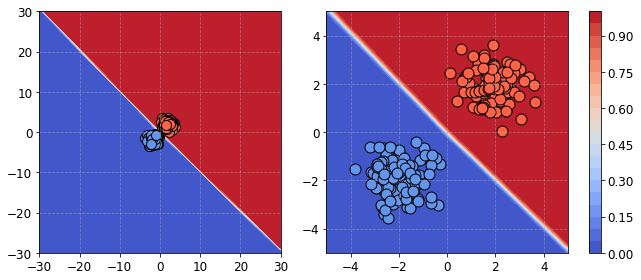

In [4]:
run_fsvi(context_type="none", cost_type="none", beta=1)

### Case (ii): FSVI with context set $\mathcal{C}$ covering the training distribution region
Here, the context set $\mathcal{C}$ covers part of the training distribution region. The results show that this type of the context set impacts the model's predictive performance to some extent, but it has a certain ability in OOD detection.

Epoch: [100/500]: NLL-loss: 0.1397, KL-loss: 7615935.0000, Loss: 761593.7875, Accuracy: 1.0000, Cost: 0.1312
Epoch: [200/500]: NLL-loss: 0.1325, KL-loss: 7364109.6000, Loss: 736411.2250, Accuracy: 1.0000, Cost: 0.1153
Epoch: [300/500]: NLL-loss: 0.0961, KL-loss: 7112368.4000, Loss: 711237.0750, Accuracy: 1.0000, Cost: 0.1237
Epoch: [400/500]: NLL-loss: 0.1085, KL-loss: 6860708.4000, Loss: 686071.0500, Accuracy: 1.0000, Cost: 0.1014
Epoch: [500/500]: NLL-loss: 0.0799, KL-loss: 6609095.4000, Loss: 660909.7750, Accuracy: 1.0000, Cost: 0.1423


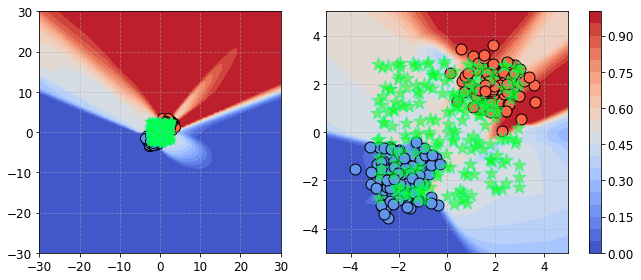

In [5]:
run_fsvi(context_type="cover", cost_type="kl_cost", beta=1)

### Case (iii): FSVI with context set $\mathcal{C}$ concentrating on a right-top out-of-distribution (OOD) region
The result shows that using context far from the training distribution helps de-tect OOD inputs in that region but still gives over-confident predictions elsewhere.
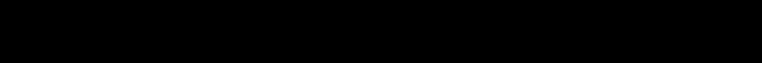

Epoch: [100/500]: NLL-loss: 0.0000, KL-loss: 7615935.2000, Loss: 761593.5375, Accuracy: 1.0000, Cost: 0.0006
Epoch: [200/500]: NLL-loss: 0.0000, KL-loss: 7364109.6000, Loss: 736410.9625, Accuracy: 1.0000, Cost: 0.0001
Epoch: [300/500]: NLL-loss: 0.0000, KL-loss: 7112368.4000, Loss: 711236.8500, Accuracy: 1.0000, Cost: 0.0000
Epoch: [400/500]: NLL-loss: 0.0000, KL-loss: 6860707.9000, Loss: 686070.8000, Accuracy: 1.0000, Cost: 0.0000
Epoch: [500/500]: NLL-loss: 0.0000, KL-loss: 6609095.3000, Loss: 660909.5375, Accuracy: 1.0000, Cost: 0.0000


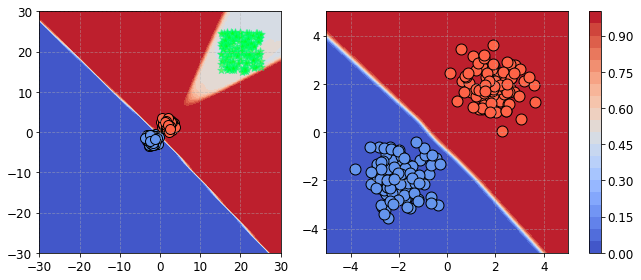

In [6]:
run_fsvi(context_type="right-top-far", cost_type="kl_cost", beta=1)

### Case (iv): FSVI with context set $\mathcal{C}$ concentrating on a left-bottom OOD region
This result is similar to the previous case.

Epoch: [100/500]: NLL-loss: 0.0000, KL-loss: 7615935.2000, Loss: 761593.5375, Accuracy: 1.0000, Cost: 0.0028
Epoch: [200/500]: NLL-loss: 0.0000, KL-loss: 7364109.6000, Loss: 736410.9625, Accuracy: 1.0000, Cost: 0.0002
Epoch: [300/500]: NLL-loss: 0.0000, KL-loss: 7112368.4000, Loss: 711236.8500, Accuracy: 1.0000, Cost: 0.0003
Epoch: [400/500]: NLL-loss: 0.0000, KL-loss: 6860708.0000, Loss: 686070.8125, Accuracy: 1.0000, Cost: 0.0000
Epoch: [500/500]: NLL-loss: 0.0000, KL-loss: 6609095.3000, Loss: 660909.5375, Accuracy: 1.0000, Cost: 0.0000


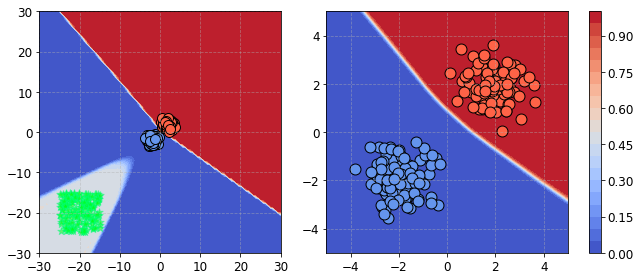

In [7]:
run_fsvi(context_type="left-bottom-far", cost_type="kl_cost", beta=1)

### Case (v): FSVI with context set $\mathcal{C}$ covering a broad OOD region

A relatively ideal case appears here, where the context set covers as much OOD space as possible. Although the classifier identifies most OOD inputs, it still produces over-confident predictions for those near the labeled in-distribution region.

One can see that as more context points are sampled from the OOD space, case (v) is expected to be similar to the following case (vi). However, in practice, this is often <u>_infeasible_</u> and <u>_computationally expensive_</u>, because the OOD space can be extremely huge, and the required context samples may be nearly infinite.
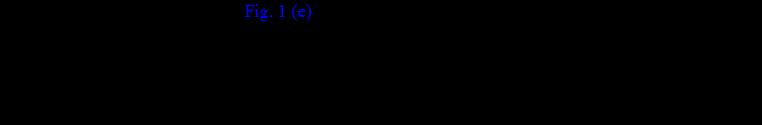

Epoch: [100/500]: NLL-loss: 0.0006, KL-loss: 7615935.0000, Loss: 761593.5125, Accuracy: 1.0000, Cost: 0.0017
Epoch: [200/500]: NLL-loss: 0.0001, KL-loss: 7364109.6000, Loss: 736410.9625, Accuracy: 1.0000, Cost: 0.0001
Epoch: [300/500]: NLL-loss: 0.0000, KL-loss: 7112368.4000, Loss: 711236.8500, Accuracy: 1.0000, Cost: 0.0000
Epoch: [400/500]: NLL-loss: 0.0000, KL-loss: 6860708.2000, Loss: 686070.8250, Accuracy: 1.0000, Cost: 0.0000
Epoch: [500/500]: NLL-loss: 0.0000, KL-loss: 6609095.4000, Loss: 660909.5500, Accuracy: 1.0000, Cost: 0.0001


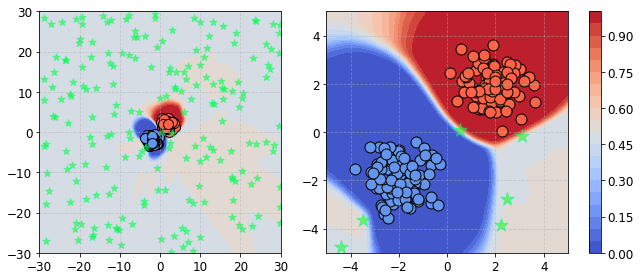

In [8]:
run_fsvi(context_type="sparse-margin", cost_type="kl_cost", beta=1)

### Case (vi): FSVI with context set $\mathcal{C}$ covering a **_“boundary”_** region **(Ours)**
This is the proposed context specification in our paper, where the context set $\mathcal{C}$ is designed to cover the boundary region of the training distribution. The results show that this context set effectively improves the model's predictive performance and the it is confident only in the labeled region, while yielding high uncertainty in all other areas.
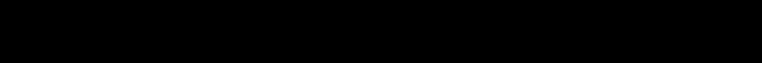

Epoch: [100/500]: NLL-loss: 0.0076, KL-loss: 7665546.2500, Loss: 766554.6406, Accuracy: 1.0000, Cost: 0.0059
Epoch: [200/500]: NLL-loss: 0.0024, KL-loss: 7464082.7500, Loss: 746408.2812, Accuracy: 1.0000, Cost: 0.0012
Epoch: [300/500]: NLL-loss: 0.0003, KL-loss: 7262627.2500, Loss: 726262.7344, Accuracy: 1.0000, Cost: 0.0002
Epoch: [400/500]: NLL-loss: 0.0001, KL-loss: 7061278.7500, Loss: 706127.8906, Accuracy: 1.0000, Cost: 0.0000
Epoch: [500/500]: NLL-loss: 0.0000, KL-loss: 6859953.0000, Loss: 685995.3125, Accuracy: 1.0000, Cost: 0.0000


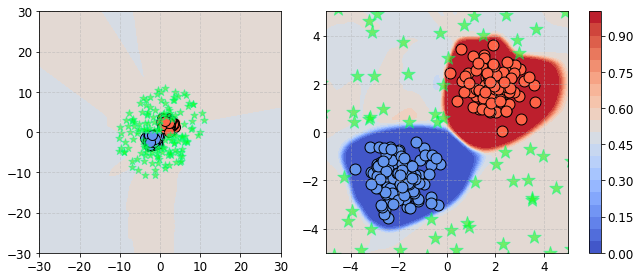

In [9]:
run_fsvi(context_type="compact-margin", cost_type="kl_cost", beta=1)

## Implementation content (2): Different cost functions comparison

Here, the impact of different cost functions on the model's predictive performance is compared using a 2D dataset (see Appendix Fig. S6 in the paper).

The significant performance improvement of our proposed KL divergence cost function has been demonstrated in the above experiments. In the following, we present the experimental results for the Mahalanobis distance cost function, corresponding to Appendix Fig. S6 (a) and (b).

Specifically, FSVI method with Mahalanobis distance cost function (Eq. (S12)) is used to optimize the BNN classifier. After training, the posterior predictive function $\mathbb{E}_{q(\boldsymbol{\theta})}\left[f\left(\mathbf{x}_* ; \boldsymbol{\theta}\right)\right]$ is plotted for all points $\mathbf{x}_*$ in the entire space (Left) and the zoomed-in region $[-5,5]^2$ (Right).

⭐ Note: The implementation details of the Mahalanobis distance cost function can be found in the `helpers.py` script, where it is approximated as a Gaussian process (GP) to accelerate the computation process.

### Case (i): Weak OOD detection performance of Mahalanobis distance cost function

(❌) The following results show that the Mahalanobis distance assigns smaller regularization to context points close to upper left and lower right corners, hereby limiting the model's OOD detection capability from propagating to a wider OOD space.

(✔️) In contrast, in the case (ii) in implementation content (1), KL divergence assigns the same regularization strength to all samples, thereby enabling the classifier to achieve partial OOD discrimination capability.

Epoch: [100/500]: NLL-loss: 0.0654, KL-loss: 7615935.0000, Loss: 761593.3250, Accuracy: 1.0000, Cost: -0.2536
Epoch: [200/500]: NLL-loss: 0.0621, KL-loss: 7364109.6000, Loss: 736410.8000, Accuracy: 1.0000, Cost: -0.2419
Epoch: [300/500]: NLL-loss: 0.0604, KL-loss: 7112368.4000, Loss: 711236.6625, Accuracy: 1.0000, Cost: -0.2546
Epoch: [400/500]: NLL-loss: 0.0756, KL-loss: 6860708.2000, Loss: 686070.6250, Accuracy: 1.0000, Cost: -0.2648
Epoch: [500/500]: NLL-loss: 0.0705, KL-loss: 6609095.4000, Loss: 660909.3625, Accuracy: 1.0000, Cost: -0.2592


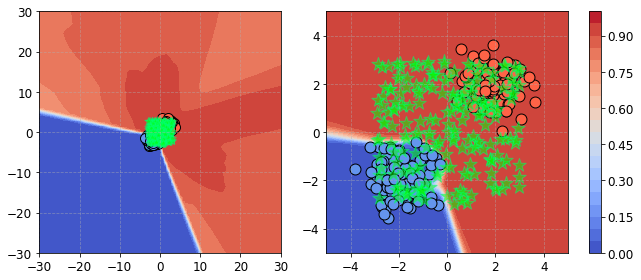

In [10]:
run_fsvi(context_type="cover", cost_type="md_cost", beta=0.05)

### Case (ii): Weak prediction accuracy

(❌) The following results show that Mahalanobis distance assigns higher regularization strength to the samples near the training distribution. Forcing the outputs of these features to be close to a uniform vector degrades the model’s prediction accuracy.

(✔️) Conversely, in the case (ii) in implementation content (1), a simpler KL divergence cost function can achieve higher prediction accuracy and better OOD detection performance.

Epoch: [100/500]: NLL-loss: 0.6932, KL-loss: 7665546.3750, Loss: 766554.7344, Accuracy: 0.4792, Cost: -0.5883
Epoch: [200/500]: NLL-loss: 0.6931, KL-loss: 7464082.7500, Loss: 746408.3750, Accuracy: 0.5052, Cost: -0.5883
Epoch: [300/500]: NLL-loss: 0.6932, KL-loss: 7262627.2500, Loss: 726262.8281, Accuracy: 0.4948, Cost: -0.5883
Epoch: [400/500]: NLL-loss: 0.6932, KL-loss: 7061278.7500, Loss: 706127.9844, Accuracy: 0.4948, Cost: -0.5883
Epoch: [500/500]: NLL-loss: 0.6932, KL-loss: 6859953.1250, Loss: 685995.4219, Accuracy: 0.4688, Cost: -0.5883


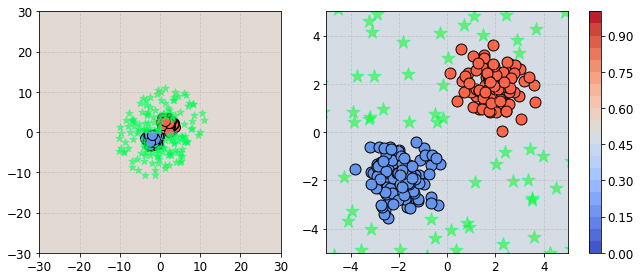

In [11]:
run_fsvi(context_type="compact-margin", cost_type="md_cost", beta=0.05)

Based on the above analysis, we suggest that, under our proposed FSVI framework, using the simpler KL divergence cost may be more beneficial for the variational optimization process, thereby improving the predictive performance.
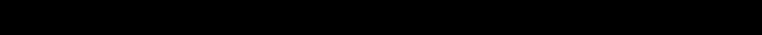